Voy a usar los datos de Temperatura, Precipitacion del dia anterior y Presion ya que son con los que mejores resultados he obtenido hasta ahora. Usaré Optuna para optimizar los modelos para obtener mejores resultados.

Ademas seguire poniendo equilibrando el undersampling solo de los datos de entrenamiento, y eligiendo parcelas enteras como datos de test.

In [1]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [2]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [3]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [4]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [5]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [6]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

Aqui cargamos en df el dataset con los datos validos:

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df[~df['parcela'].isin(parcelasAQuitar2)]
df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
df = quitarDatosMalos(df)

In [34]:
df

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,pres
0,22_27_0_1_503_5017_1,292,0.013078,0.008582,-0.002236,0.456587,0,17.4,0.0,959.5
1,22_27_0_1_503_5017_1,293,0.011039,0.005081,-0.006042,0.467762,0,18.0,0.0,961.3499999999999
2,22_27_0_1_503_5017_1,294,0.008906,0.001723,-0.008617,0.478748,0,17.6,0.0,957.0
3,22_27_0_1_503_5017_1,295,0.006757,-0.001304,-0.009899,0.488632,0,15.5,0.0,953.3499999999999
4,22_27_0_1_503_5017_1,296,0.004652,-0.003832,-0.010032,0.496736,0,13.7,0.0,955.45
...,...,...,...,...,...,...,...,...,...,...
8155,50_224_0_2_18_50_1,289,0.005049,0.004059,0.004025,0.414865,0,16.8,0.0,988.5
8156,50_224_0_2_18_50_1,290,0.005029,0.004006,0.004614,0.409131,0,16.4,0.0,987.8
8157,50_224_0_2_18_50_1,291,0.004980,0.004131,0.005174,0.402966,0,17.8,0.2,989.25
8158,50_224_0_2_18_50_1,292,0.004917,0.004413,0.005670,0.396435,0,18.8,0.0,992.95


In [66]:
type(df['tmed'][0])

numpy.float64

In [8]:
def obtenerParametrosOptimosXGBoost(carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials = 100):
    import warnings
    warnings.filterwarnings("ignore")
    import pandas as pd
    import numpy as np

    df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
    parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
    parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    df = df[~df['parcela'].isin(parcelasAQuitar2)]
    df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
    df = quitarDatosMalos(df)
    df = df.astype(float)


    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    import optuna
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_auc_score
    import joblib


    import os

    def objective(trial):
        # Definir los parámetros a optimizar
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_uniform('gamma', 0, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'n_jobs': -1
        }

        # Crear el modelo XGBoost con los parámetros optimizados
        model = xgb.XGBClassifier(**params)

        # Definir la k-fold cross-validation
        parcelas = df['parcela'].unique() # obtenemos las parcelas
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        scores = []
        for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
            # obtenemos las parcelas de train y test
            parcelasTrain = parcelas[train_index]
            parcelasTest = parcelas[test_index]

            # separamos en 2 df segun las parcelas de train o test
            df_train = df[df['parcela'].isin(parcelasTrain)]
            df_test = df[df['parcela'].isin(parcelasTest)]

            # preparo la normalizacion
            scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

            # arreglamos undersampling en los datos de train
            smote = SMOTE(sampling_strategy=1, random_state=random_state)
            X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_train)

            # preparamos datos de test
            X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
            X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_test)

            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, y_pred)
            scores.append(score)

        # Calcular el valor medio del ROC AUC para todos los folds
        score = np.max(scores)

        # Guardar el modelo con los parámetros y la puntuación
        filename = os.path.join(carpeta, f"model_trial_{trial.number}.joblib")
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
        joblib.dump((params, score, model), filename)

        return score
    
    
    # Crear el optimizador de Optuna
    study = optuna.create_study(direction='maximize')

    # Ejecutar la optimización
    study.optimize(objective, n_trials=n_trials)

    # Obtener el mejor conjunto de parámetros y su puntuación
    best_params = study.best_params
    best_score = study.best_value

    print(f'Best params: {best_params}')
    print(f'Best ROC AUC: {best_score}')

    # obtiene el número de prueba del mejor modelo
    best_trial = study.best_trial
    num_trial_best = best_trial.number
    
    # muestra el número de prueba del mejor modelo
    print(f"El mejor modelo fue el número de prueba {num_trial_best}.")
    
    return num_trial_best

In [9]:
import os
import joblib
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
def probarMejorModelo(best_model, n_splits = 10, umbral=0.5, random_state = 33, normalizacion=[0,1]):
    from sklearn.metrics import classification_report
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = df[df['parcela'].isin(parcelasTest)]

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_train)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_test)
        
        dtrain = X_train
        dtest = X_test
        
        model = best_model
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0)
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        score = roc_auc_score(y_test, y_pred)
        print(f'Test ROC AUC: {score}')
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       525
           1       0.71      0.73      0.72       175

    accuracy                           0.86       700
   macro avg       0.81      0.81      0.81       700
weighted avg       0.86      0.86      0.86       700



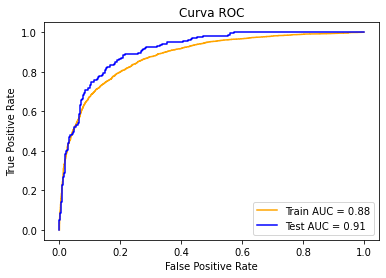

Parcelas con acierto:  32 de 35   91.43%
Test ROC AUC: 0.9097578231292517
Exito min:  0.37350112 
Exito max:  0.8729751 
Exito promedio:  0.6788309565686839
Exito * accuracy =  0.5818551056303004
Exito * accuracy / (Exito + accuracy) =  0.3788183759619576
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       525
           1       0.75      0.81      0.78       175

    accuracy                           0.88       700
   macro avg       0.84      0.86      0.85       700
weighted avg       0.89      0.88      0.89       700



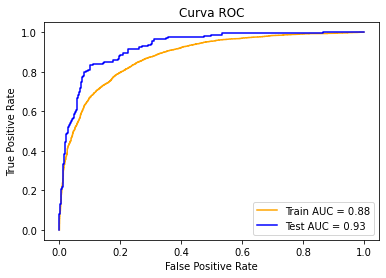

Parcelas con acierto:  33 de 35   94.29%
Test ROC AUC: 0.9266068027210885
Exito min:  0.49960637 
Exito max:  0.85203356 
Exito promedio:  0.6918772390197313
Exito * accuracy =  0.611817158504591
Exito * accuracy / (Exito + accuracy) =  0.3881687215281392
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       525
           1       0.48      0.46      0.47       175

    accuracy                           0.74       700
   macro avg       0.65      0.65      0.65       700
weighted avg       0.74      0.74      0.74       700



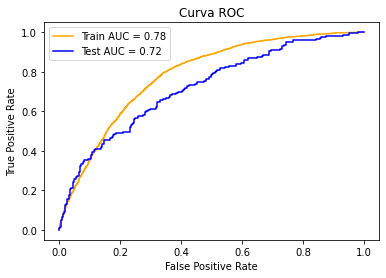

Parcelas con acierto:  29 de 35   82.86%
Test ROC AUC: 0.721208163265306
Exito min:  0.24946185703207516 
Exito max:  0.8895559 
Exito promedio:  0.5971052014289588
Exito * accuracy =  0.44271085648804237
Exito * accuracy / (Exito + accuracy) =  0.33074313511188724
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       525
           1       0.70      0.67      0.68       175

    accuracy                           0.84       700
   macro avg       0.79      0.79      0.79       700
weighted avg       0.84      0.84      0.84       700



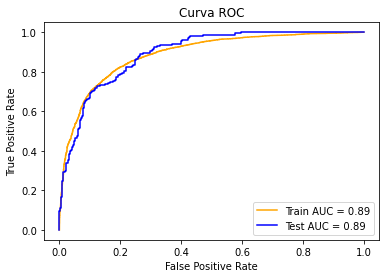

Parcelas con acierto:  33 de 35   94.29%
Test ROC AUC: 0.8936489795918368
Exito min:  0.43926518469475734 
Exito max:  0.8757411 
Exito promedio:  0.67773724994164
Exito * accuracy =  0.5722038781650132
Exito * accuracy / (Exito + accuracy) =  0.37594956949646885
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       525
           1       0.70      0.61      0.65       175

    accuracy                           0.84       700
   macro avg       0.79      0.76      0.77       700
weighted avg       0.83      0.84      0.83       700



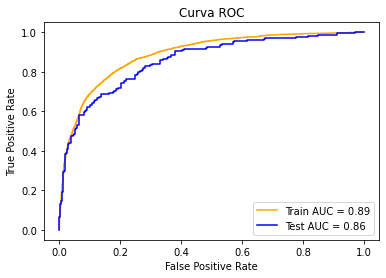

Parcelas con acierto:  32 de 35   91.43%
Test ROC AUC: 0.8569034013605441
Exito min:  0.275455545930493 
Exito max:  0.852882 
Exito promedio:  0.6313114100217401
Exito * accuracy =  0.5275959640895971
Exito * accuracy / (Exito + accuracy) =  0.35963648463900655
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       525
           1       0.53      0.25      0.34       175

    accuracy                           0.76       700
   macro avg       0.66      0.59      0.59       700
weighted avg       0.72      0.76      0.72       700



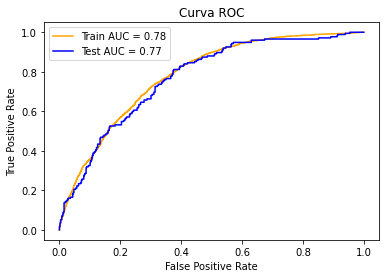

Parcelas con acierto:  17 de 35   48.57%
Test ROC AUC: 0.7695074829931974
Exito min:  0.24962544 
Exito max:  0.87513113 
Exito promedio:  0.5223999656572106
Exito * accuracy =  0.39553140256903085
Exito * accuracy / (Exito + accuracy) =  0.3091193163066444
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       510
           1       0.66      0.66      0.66       170

    accuracy                           0.83       680
   macro avg       0.78      0.78      0.78       680
weighted avg       0.83      0.83      0.83       680



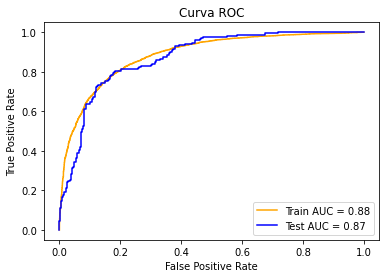

Parcelas con acierto:  32 de 34   94.12%
Test ROC AUC: 0.8733217993079584
Exito min:  0.46390340523500895 
Exito max:  0.8131275 
Exito promedio:  0.6530290228892716
Exito * accuracy =  0.5435506278754819
Exito * accuracy / (Exito + accuracy) =  0.3659332353731371
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       510
           1       0.72      0.66      0.69       170

    accuracy                           0.85       680
   macro avg       0.81      0.79      0.80       680
weighted avg       0.85      0.85      0.85       680



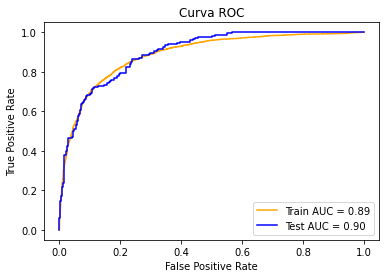

Parcelas con acierto:  29 de 34   85.29%
Test ROC AUC: 0.8968281430219146
Exito min:  0.42838773 
Exito max:  0.8707911 
Exito promedio:  0.6445915427389951
Exito * accuracy =  0.5488507400674679
Exito * accuracy / (Exito + accuracy) =  0.36686360058458045
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       510
           1       0.67      0.61      0.64       170

    accuracy                           0.83       680
   macro avg       0.77      0.75      0.76       680
weighted avg       0.82      0.83      0.82       680



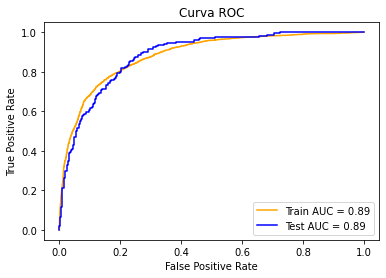

Parcelas con acierto:  30 de 34   88.24%
Test ROC AUC: 0.8861476355247981
Exito min:  0.40089375263704274 
Exito max:  0.8329199 
Exito promedio:  0.64642531983164
Exito * accuracy =  0.5342515143314436
Exito * accuracy / (Exito + accuracy) =  0.36272184029121846
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       510
           1       0.60      0.48      0.53       170

    accuracy                           0.79       680
   macro avg       0.72      0.69      0.70       680
weighted avg       0.78      0.79      0.78       680



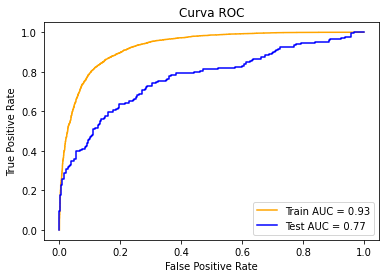

Parcelas con acierto:  26 de 34   76.47%
Test ROC AUC: 0.7693310265282584
Exito min:  0.23763807 
Exito max:  0.8485473 
Exito promedio:  0.5876025791830989
Exito * accuracy =  0.4640332132666531
Exito * accuracy / (Exito + accuracy) =  0.3369130635770154


[I 2023-03-03 11:27:27,280] A new study created in memory with name: no-name-1e9d1757-309d-4c6b-bc85-619709ea153d
[I 2023-03-03 11:27:30,577] Trial 0 finished with value: 0.7087292517006804 and parameters: {'max_depth': 2, 'learning_rate': 0.03961979637708683, 'subsample': 0.746044203019208, 'colsample_bytree': 0.9157578747310879, 'gamma': 2.777823211861241, 'min_child_weight': 6.770081083948746, 'reg_alpha': 5.980579501818837, 'reg_lambda': 5.016141710438663}. Best is trial 0 with value: 0.7087292517006804.
[I 2023-03-03 11:27:36,548] Trial 1 finished with value: 0.8010013605442178 and parameters: {'max_depth': 5, 'learning_rate': 0.07224788844249705, 'subsample': 0.9120759782336909, 'colsample_bytree': 0.6273002805181767, 'gamma': 2.2247974364819276, 'min_child_weight': 7.075306425538961, 'reg_alpha': 8.721665354591948, 'reg_lambda': 2.341523774679671}. Best is trial 1 with value: 0.8010013605442178.
[I 2023-03-03 11:27:40,943] Trial 2 finished with value: 0.7556517006802721 and para

[I 2023-03-03 11:31:02,172] Trial 20 finished with value: 0.8311619047619048 and parameters: {'max_depth': 7, 'learning_rate': 0.08851300118367916, 'subsample': 0.8665982376687086, 'colsample_bytree': 0.7689670009261433, 'gamma': 8.45388151060427, 'min_child_weight': 4.444076043695968, 'reg_alpha': 5.264747599707184, 'reg_lambda': 1.5924601465061237}. Best is trial 17 with value: 0.8483428571428572.
[I 2023-03-03 11:31:16,621] Trial 21 finished with value: 0.8382929642445214 and parameters: {'max_depth': 9, 'learning_rate': 0.08733130868577711, 'subsample': 0.7698790513697389, 'colsample_bytree': 0.7748310965689256, 'gamma': 6.462554639097528, 'min_child_weight': 1.359189260992985, 'reg_alpha': 3.1177139524112985, 'reg_lambda': 0.9612595968041072}. Best is trial 17 with value: 0.8483428571428572.
[I 2023-03-03 11:31:29,958] Trial 22 finished with value: 0.8315340253748559 and parameters: {'max_depth': 9, 'learning_rate': 0.0994795010134562, 'subsample': 0.7861790821250697, 'colsample_b

[I 2023-03-03 11:35:24,620] Trial 40 finished with value: 0.8374095238095238 and parameters: {'max_depth': 8, 'learning_rate': 0.0782283512522771, 'subsample': 0.862977745018088, 'colsample_bytree': 0.890393075862608, 'gamma': 5.024447938181409, 'min_child_weight': 6.835726658246308, 'reg_alpha': 5.876289795085654, 'reg_lambda': 1.817710045674343}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:35:40,331] Trial 41 finished with value: 0.8529197278911566 and parameters: {'max_depth': 10, 'learning_rate': 0.09871562048609094, 'subsample': 0.9039518318137824, 'colsample_bytree': 0.976896401225778, 'gamma': 5.886970336914845, 'min_child_weight': 4.565473550450077, 'reg_alpha': 4.197548001238395, 'reg_lambda': 2.3960879567321447}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:35:56,114] Trial 42 finished with value: 0.8431891156462584 and parameters: {'max_depth': 10, 'learning_rate': 0.09140030218233354, 'subsample': 0.9220589002313059, 'colsample_byt

[I 2023-03-03 11:40:26,567] Trial 60 finished with value: 0.8529296424452134 and parameters: {'max_depth': 9, 'learning_rate': 0.0892524495110943, 'subsample': 0.8871814477398938, 'colsample_bytree': 0.9648882517225941, 'gamma': 5.730469362369075, 'min_child_weight': 3.7329133969486827, 'reg_alpha': 3.2363620415303354, 'reg_lambda': 0.7484821813714799}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:40:41,318] Trial 61 finished with value: 0.8440715109573241 and parameters: {'max_depth': 9, 'learning_rate': 0.08848030188072262, 'subsample': 0.8785740379458048, 'colsample_bytree': 0.966938372165047, 'gamma': 5.752519578916096, 'min_child_weight': 3.6790031699861987, 'reg_alpha': 3.2731695121085456, 'reg_lambda': 0.8722890571877013}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:40:54,579] Trial 62 finished with value: 0.8498122448979593 and parameters: {'max_depth': 8, 'learning_rate': 0.0898438003121896, 'subsample': 0.890655869187211, 'colsample_

[I 2023-03-03 11:45:15,362] Trial 80 finished with value: 0.844560544217687 and parameters: {'max_depth': 8, 'learning_rate': 0.09761609666312851, 'subsample': 0.9032979823016265, 'colsample_bytree': 0.9190578272348664, 'gamma': 5.525247755607473, 'min_child_weight': 5.235130320408066, 'reg_alpha': 1.881538749780387, 'reg_lambda': 2.28476266362465}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:45:31,344] Trial 81 finished with value: 0.850857142857143 and parameters: {'max_depth': 10, 'learning_rate': 0.09047299339168915, 'subsample': 0.8774300842138006, 'colsample_bytree': 0.9625991941577366, 'gamma': 5.891119693641454, 'min_child_weight': 4.952146974857342, 'reg_alpha': 3.9887913598889257, 'reg_lambda': 0.8049764755440445}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:45:47,127] Trial 82 finished with value: 0.8531809523809524 and parameters: {'max_depth': 10, 'learning_rate': 0.09364818092096776, 'subsample': 0.8598563140616842, 'colsample_b

[I 2023-03-03 11:50:27,221] Trial 100 finished with value: 0.8478911564625851 and parameters: {'max_depth': 10, 'learning_rate': 0.09560952803197399, 'subsample': 0.8980931964981131, 'colsample_bytree': 0.9880622527195612, 'gamma': 5.080001356942885, 'min_child_weight': 5.659460267637109, 'reg_alpha': 2.852097046202628, 'reg_lambda': 1.8865335266254024}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:50:44,723] Trial 101 finished with value: 0.8415945578231292 and parameters: {'max_depth': 9, 'learning_rate': 0.09344944263523791, 'subsample': 0.8864593627683559, 'colsample_bytree': 0.960507470019375, 'gamma': 5.80956124237223, 'min_child_weight': 6.018366936021772, 'reg_alpha': 3.267990002000387, 'reg_lambda': 0.8834206146516631}. Best is trial 28 with value: 0.8573278911564627.
[I 2023-03-03 11:51:02,391] Trial 102 finished with value: 0.8527346938775511 and parameters: {'max_depth': 9, 'learning_rate': 0.09679622142014642, 'subsample': 0.8914996519848972, 'colsampl

[I 2023-03-03 11:59:20,483] Trial 120 finished with value: 0.8507266435986158 and parameters: {'max_depth': 10, 'learning_rate': 0.08759914619686701, 'subsample': 0.922562516633949, 'colsample_bytree': 0.9995326444536737, 'gamma': 4.259165241636895, 'min_child_weight': 6.901446689640823, 'reg_alpha': 3.8014938948883503, 'reg_lambda': 1.7140989297216143}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 11:59:45,834] Trial 121 finished with value: 0.8443700680272108 and parameters: {'max_depth': 10, 'learning_rate': 0.09287313176797729, 'subsample': 0.8822143095540527, 'colsample_bytree': 0.9750402170353403, 'gamma': 5.081137346217851, 'min_child_weight': 5.597128566102914, 'reg_alpha': 4.267832440685219, 'reg_lambda': 1.9728793862124274}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:00:10,814] Trial 122 finished with value: 0.8441407151095732 and parameters: {'max_depth': 10, 'learning_rate': 0.09482424378314612, 'subsample': 0.8647457760016717, 'co

[I 2023-03-03 12:06:40,869] Trial 140 finished with value: 0.8429877551020409 and parameters: {'max_depth': 10, 'learning_rate': 0.09320731732002424, 'subsample': 0.9131658236344963, 'colsample_bytree': 0.9774923099689345, 'gamma': 5.112406709877309, 'min_child_weight': 5.363018596177215, 'reg_alpha': 2.0678169036740233, 'reg_lambda': 2.7501061411840824}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:07:02,023] Trial 141 finished with value: 0.8499102040816326 and parameters: {'max_depth': 10, 'learning_rate': 0.09718511445516752, 'subsample': 0.9247839552075674, 'colsample_bytree': 0.9788185287190755, 'gamma': 5.648635919189558, 'min_child_weight': 7.126082112601487, 'reg_alpha': 3.3579668978159276, 'reg_lambda': 1.6885114189732717}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:07:22,484] Trial 142 finished with value: 0.8508408163265306 and parameters: {'max_depth': 10, 'learning_rate': 0.09987509643744255, 'subsample': 0.9301282254374375, '

[I 2023-03-03 12:13:21,026] Trial 160 finished with value: 0.8451809523809524 and parameters: {'max_depth': 9, 'learning_rate': 0.09563599488963, 'subsample': 0.8529105737183089, 'colsample_bytree': 0.9908653220373749, 'gamma': 6.11832831884311, 'min_child_weight': 4.794642465811984, 'reg_alpha': 3.96622208015763, 'reg_lambda': 0.15370965029360334}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:13:39,953] Trial 161 finished with value: 0.8465088435374148 and parameters: {'max_depth': 10, 'learning_rate': 0.09777915107785262, 'subsample': 0.9363354734235737, 'colsample_bytree': 0.8236284015267253, 'gamma': 5.1463964054731335, 'min_child_weight': 6.27502702250544, 'reg_alpha': 3.560225403792745, 'reg_lambda': 0.9744642416416546}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:14:04,455] Trial 162 finished with value: 0.8517301038062284 and parameters: {'max_depth': 10, 'learning_rate': 0.09368289190651942, 'subsample': 0.9054771744846938, 'colsamp

[I 2023-03-03 12:20:58,830] Trial 180 finished with value: 0.8534204081632653 and parameters: {'max_depth': 10, 'learning_rate': 0.09158843565380738, 'subsample': 0.9122362964094308, 'colsample_bytree': 0.91337759179753, 'gamma': 7.161510204772564, 'min_child_weight': 6.622079789053658, 'reg_alpha': 2.6241627294128853, 'reg_lambda': 0.7925064568974183}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:21:22,354] Trial 181 finished with value: 0.8466721088435374 and parameters: {'max_depth': 10, 'learning_rate': 0.09139899561683183, 'subsample': 0.9105698779063968, 'colsample_bytree': 0.9337031580765306, 'gamma': 7.298201452958496, 'min_child_weight': 6.613885685736164, 'reg_alpha': 2.6647889887204244, 'reg_lambda': 0.7294545919501799}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:21:46,603] Trial 182 finished with value: 0.8489687074829932 and parameters: {'max_depth': 10, 'learning_rate': 0.09327603416535274, 'subsample': 0.9006260011319003, 'co

[I 2023-03-03 12:29:25,924] Trial 200 finished with value: 0.8480653061224489 and parameters: {'max_depth': 10, 'learning_rate': 0.09050954044029624, 'subsample': 0.9202611181504129, 'colsample_bytree': 0.9558175044890057, 'gamma': 3.5025590518186775, 'min_child_weight': 7.196229585685179, 'reg_alpha': 3.536044808086798, 'reg_lambda': 0.8785855376273786}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:29:51,480] Trial 201 finished with value: 0.8454965986394557 and parameters: {'max_depth': 10, 'learning_rate': 0.09443691965939968, 'subsample': 0.9082960306511748, 'colsample_bytree': 0.9467317975697965, 'gamma': 6.472487945105939, 'min_child_weight': 6.03548602530931, 'reg_alpha': 2.5698159623538155, 'reg_lambda': 1.937378563121511}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:30:11,393] Trial 202 finished with value: 0.8405074971164938 and parameters: {'max_depth': 10, 'learning_rate': 0.09316882429886858, 'subsample': 0.9126048428015392, 'co

[I 2023-03-03 12:36:18,248] Trial 220 finished with value: 0.8470934256055364 and parameters: {'max_depth': 10, 'learning_rate': 0.0985810227804002, 'subsample': 0.7844136598304638, 'colsample_bytree': 0.9799987731226015, 'gamma': 3.9204573882843046, 'min_child_weight': 6.689141646026179, 'reg_alpha': 2.8896079187278723, 'reg_lambda': 0.4206054279513311}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:36:34,085] Trial 221 finished with value: 0.8480326530612247 and parameters: {'max_depth': 10, 'learning_rate': 0.09991531673088222, 'subsample': 0.9435046759956348, 'colsample_bytree': 0.9703613806388424, 'gamma': 4.279407515168927, 'min_child_weight': 6.872847846166909, 'reg_alpha': 3.4977119512900074, 'reg_lambda': 0.27528963536292667}. Best is trial 106 with value: 0.8583401360544217.
[I 2023-03-03 12:36:49,877] Trial 222 finished with value: 0.8556734693877552 and parameters: {'max_depth': 10, 'learning_rate': 0.0966421443141515, 'subsample': 0.9353640340768034, '

[I 2023-03-03 12:42:04,490] Trial 240 finished with value: 0.8476734693877551 and parameters: {'max_depth': 10, 'learning_rate': 0.06435004225075053, 'subsample': 0.9842698917781242, 'colsample_bytree': 0.99910720072892, 'gamma': 3.47303129532954, 'min_child_weight': 6.887180547661959, 'reg_alpha': 3.0657802793160545, 'reg_lambda': 0.3914780254332244}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:42:22,342] Trial 241 finished with value: 0.8469115646258503 and parameters: {'max_depth': 10, 'learning_rate': 0.08178091662160698, 'subsample': 0.9978907066733206, 'colsample_bytree': 0.9849116404786064, 'gamma': 3.9501709763890505, 'min_child_weight': 6.7872645064946155, 'reg_alpha': 3.271663059365261, 'reg_lambda': 0.11750054699503595}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:42:39,439] Trial 242 finished with value: 0.8509061224489796 and parameters: {'max_depth': 10, 'learning_rate': 0.07799404834617271, 'subsample': 0.9386775932433173, 'c

[I 2023-03-03 12:47:49,353] Trial 260 finished with value: 0.8533823129251701 and parameters: {'max_depth': 10, 'learning_rate': 0.09527480968635656, 'subsample': 0.9626074356959279, 'colsample_bytree': 0.9635124926663987, 'gamma': 3.2795507527427508, 'min_child_weight': 7.332358700254364, 'reg_alpha': 4.057970741488027, 'reg_lambda': 0.767769468621698}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:48:06,937] Trial 261 finished with value: 0.8429757785467128 and parameters: {'max_depth': 10, 'learning_rate': 0.09372207783348976, 'subsample': 0.9501646361659976, 'colsample_bytree': 0.867087284742409, 'gamma': 4.548707246213772, 'min_child_weight': 3.107796374104825, 'reg_alpha': 4.339234597400453, 'reg_lambda': 0.38035541926754346}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:48:25,151] Trial 262 finished with value: 0.843461224489796 and parameters: {'max_depth': 10, 'learning_rate': 0.07540157140399345, 'subsample': 0.9428247011134385, 'col

[I 2023-03-03 12:54:00,547] Trial 280 finished with value: 0.8503619047619048 and parameters: {'max_depth': 10, 'learning_rate': 0.06996375875748168, 'subsample': 0.9844535824807928, 'colsample_bytree': 0.8489550652382194, 'gamma': 4.619300526451777, 'min_child_weight': 1.149138256206178, 'reg_alpha': 0.3354260824854888, 'reg_lambda': 0.9551718693529443}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:54:19,362] Trial 281 finished with value: 0.8411102040816326 and parameters: {'max_depth': 10, 'learning_rate': 0.07143937932571953, 'subsample': 0.9996417566204772, 'colsample_bytree': 0.9741941719823292, 'gamma': 9.487607659914495, 'min_child_weight': 0.3994533379592292, 'reg_alpha': 0.3034841591418835, 'reg_lambda': 0.6343055374921334}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:54:36,581] Trial 282 finished with value: 0.8511782312925171 and parameters: {'max_depth': 10, 'learning_rate': 0.06705842171779049, 'subsample': 0.9723969142791438, 

[I 2023-03-03 12:59:36,470] Trial 300 finished with value: 0.8534717416378316 and parameters: {'max_depth': 9, 'learning_rate': 0.07216991962959408, 'subsample': 0.9803722883135861, 'colsample_bytree': 0.8445662455928041, 'gamma': 4.044151420530115, 'min_child_weight': 0.44026226047173833, 'reg_alpha': 0.7583379610806007, 'reg_lambda': 0.015857469661191545}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 12:59:54,893] Trial 301 finished with value: 0.8403748558246827 and parameters: {'max_depth': 9, 'learning_rate': 0.05861875191304424, 'subsample': 0.9999468437951415, 'colsample_bytree': 0.8998009282846098, 'gamma': 4.6245321789869385, 'min_child_weight': 0.9498221583031181, 'reg_alpha': 1.0251993303360085, 'reg_lambda': 2.8697883349347495}. Best is trial 231 with value: 0.8657088435374151.
[I 2023-03-03 13:00:12,982] Trial 302 finished with value: 0.8666448979591836 and parameters: {'max_depth': 9, 'learning_rate': 0.07133033805147969, 'subsample': 0.9873552247588132

[I 2023-03-03 13:05:21,231] Trial 320 finished with value: 0.8458503401360544 and parameters: {'max_depth': 10, 'learning_rate': 0.07303079888719648, 'subsample': 0.9234110986475685, 'colsample_bytree': 0.9548571914963889, 'gamma': 3.4902336258675786, 'min_child_weight': 3.0401391683133245, 'reg_alpha': 4.592426235436118, 'reg_lambda': 1.6431831401572214}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:05:35,733] Trial 321 finished with value: 0.8359183673469388 and parameters: {'max_depth': 8, 'learning_rate': 0.06826341811967988, 'subsample': 0.9784462839947897, 'colsample_bytree': 0.8741162349772014, 'gamma': 4.9083154010095065, 'min_child_weight': 2.1359356060159365, 'reg_alpha': 0.5954676185959696, 'reg_lambda': 3.897651799545886}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:05:54,727] Trial 322 finished with value: 0.8517224489795918 and parameters: {'max_depth': 10, 'learning_rate': 0.0661272731089292, 'subsample': 0.914693832823583, 'c

[I 2023-03-03 13:10:52,357] Trial 340 finished with value: 0.8450938775510204 and parameters: {'max_depth': 10, 'learning_rate': 0.07216398824410455, 'subsample': 0.9829202357403032, 'colsample_bytree': 0.9514379752730177, 'gamma': 5.569025745924693, 'min_child_weight': 0.03473633293427536, 'reg_alpha': 1.0038910453574958, 'reg_lambda': 4.30524645547565}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:11:09,791] Trial 341 finished with value: 0.8633578231292517 and parameters: {'max_depth': 10, 'learning_rate': 0.08372432921298481, 'subsample': 0.9997053151304787, 'colsample_bytree': 0.9641165858055025, 'gamma': 4.574017289405985, 'min_child_weight': 0.8209422386463223, 'reg_alpha': 0.24653945314509063, 'reg_lambda': 1.1031216098902634}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:11:27,169] Trial 342 finished with value: 0.8502748299319728 and parameters: {'max_depth': 10, 'learning_rate': 0.08346168757030192, 'subsample': 0.9959116078202034,

[I 2023-03-03 13:16:47,645] Trial 360 finished with value: 0.8567183673469386 and parameters: {'max_depth': 9, 'learning_rate': 0.08218370959616032, 'subsample': 0.9765346782349508, 'colsample_bytree': 0.9574536781697282, 'gamma': 2.806502584102763, 'min_child_weight': 1.1307956327389217, 'reg_alpha': 0.4953961604574789, 'reg_lambda': 0.9734840206619181}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:17:03,894] Trial 361 finished with value: 0.8634884353741498 and parameters: {'max_depth': 9, 'learning_rate': 0.08434738090802142, 'subsample': 0.9744815628911566, 'colsample_bytree': 0.9653453273624395, 'gamma': 2.5564265905846533, 'min_child_weight': 1.329369105818326, 'reg_alpha': 0.5378410087093528, 'reg_lambda': 0.8287509606521805}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:17:20,160] Trial 362 finished with value: 0.8582421768707482 and parameters: {'max_depth': 9, 'learning_rate': 0.08302375325556816, 'subsample': 0.9715617389032635, 'c

[I 2023-03-03 13:22:22,554] Trial 380 finished with value: 0.8492272202998847 and parameters: {'max_depth': 9, 'learning_rate': 0.08823110339117894, 'subsample': 0.9539687869464616, 'colsample_bytree': 0.948119354459514, 'gamma': 2.7091931273679575, 'min_child_weight': 1.227132497788301, 'reg_alpha': 0.9924545647285177, 'reg_lambda': 1.405483155709553}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:22:39,725] Trial 381 finished with value: 0.8581314878892734 and parameters: {'max_depth': 9, 'learning_rate': 0.08510769238904507, 'subsample': 0.9605051609980939, 'colsample_bytree': 0.9578608531912951, 'gamma': 2.188088501971371, 'min_child_weight': 1.3082485902104577, 'reg_alpha': 0.7058856978999796, 'reg_lambda': 1.2035434941119738}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:22:56,645] Trial 382 finished with value: 0.8579584775086504 and parameters: {'max_depth': 9, 'learning_rate': 0.08548387718631838, 'subsample': 0.9618855623730688, 'col

[I 2023-03-03 13:28:09,501] Trial 400 finished with value: 0.8525714285714286 and parameters: {'max_depth': 9, 'learning_rate': 0.08734224122679621, 'subsample': 0.9679590899197592, 'colsample_bytree': 0.8175131112790953, 'gamma': 2.003147659760895, 'min_child_weight': 1.7212828949798828, 'reg_alpha': 1.3297263619044042, 'reg_lambda': 1.0587034618877817}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:28:27,197] Trial 401 finished with value: 0.8525028835063437 and parameters: {'max_depth': 9, 'learning_rate': 0.0842917111787272, 'subsample': 0.9735956240763183, 'colsample_bytree': 0.9480830898401204, 'gamma': 2.9648137385619266, 'min_child_weight': 1.4696436212135713, 'reg_alpha': 1.1137946875231484, 'reg_lambda': 1.462978031519701}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:28:43,054] Trial 402 finished with value: 0.8556978085351787 and parameters: {'max_depth': 9, 'learning_rate': 0.0821307588653, 'subsample': 0.9510656792955917, 'colsam

[I 2023-03-03 13:34:06,830] Trial 420 finished with value: 0.8558911564625852 and parameters: {'max_depth': 9, 'learning_rate': 0.08520096659475672, 'subsample': 0.981761414816542, 'colsample_bytree': 0.749582686563573, 'gamma': 1.5693934749748495, 'min_child_weight': 3.469668207605584, 'reg_alpha': 0.7240369880294807, 'reg_lambda': 1.1162568093050766}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:34:21,124] Trial 421 finished with value: 0.8558040816326531 and parameters: {'max_depth': 8, 'learning_rate': 0.0831775644090015, 'subsample': 0.9614278049130919, 'colsample_bytree': 0.827704137333898, 'gamma': 2.071601809164008, 'min_child_weight': 1.0193535636621665, 'reg_alpha': 0.4497165210838644, 'reg_lambda': 1.6537666766775665}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:34:38,776] Trial 422 finished with value: 0.8567012687427912 and parameters: {'max_depth': 9, 'learning_rate': 0.07990183525519289, 'subsample': 0.9720434701178882, 'colsa

[I 2023-03-03 13:39:43,173] Trial 440 finished with value: 0.8552249134948097 and parameters: {'max_depth': 9, 'learning_rate': 0.08448852897390105, 'subsample': 0.799545720740816, 'colsample_bytree': 0.8594134416033659, 'gamma': 2.3261894262331357, 'min_child_weight': 2.772201544986844, 'reg_alpha': 0.9982816968244101, 'reg_lambda': 0.824973722089126}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:39:51,121] Trial 441 finished with value: 0.7660843537414966 and parameters: {'max_depth': 3, 'learning_rate': 0.07695602004543158, 'subsample': 0.9750529180342983, 'colsample_bytree': 0.8792110231932054, 'gamma': 2.9160096738953634, 'min_child_weight': 3.1844811916288602, 'reg_alpha': 0.47445972350366805, 'reg_lambda': 4.429869679324522}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:40:07,227] Trial 442 finished with value: 0.836885813148789 and parameters: {'max_depth': 9, 'learning_rate': 0.08059992283869741, 'subsample': 0.7195039830175775, 'col

[I 2023-03-03 13:45:32,923] Trial 460 finished with value: 0.8596885813148788 and parameters: {'max_depth': 9, 'learning_rate': 0.08760371147255669, 'subsample': 0.7894210480801035, 'colsample_bytree': 0.8505875461086763, 'gamma': 1.5405390609686984, 'min_child_weight': 0.5679223464611985, 'reg_alpha': 1.4228915611929356, 'reg_lambda': 1.9073061275993943}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:45:55,931] Trial 461 finished with value: 0.8571626297577855 and parameters: {'max_depth': 9, 'learning_rate': 0.08824644277367184, 'subsample': 0.7947485134189362, 'colsample_bytree': 0.8509691313421308, 'gamma': 1.5361256251798896, 'min_child_weight': 0.3948848243679576, 'reg_alpha': 1.1782896150348467, 'reg_lambda': 2.218889228207946}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:46:16,843] Trial 462 finished with value: 0.8541176470588236 and parameters: {'max_depth': 9, 'learning_rate': 0.08769733106245929, 'subsample': 0.7866104162692586, '

[I 2023-03-03 13:50:41,838] Trial 480 finished with value: 0.8383391003460208 and parameters: {'max_depth': 9, 'learning_rate': 0.0892619705501885, 'subsample': 0.8005084720771776, 'colsample_bytree': 0.839402213174096, 'gamma': 1.348146727797228, 'min_child_weight': 0.36354987151375573, 'reg_alpha': 5.308437178241274, 'reg_lambda': 6.459891574163159}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:50:56,432] Trial 481 finished with value: 0.8469434832756632 and parameters: {'max_depth': 9, 'learning_rate': 0.07819391646023242, 'subsample': 0.7833793166721245, 'colsample_bytree': 0.7982778701625891, 'gamma': 1.9355495979764885, 'min_child_weight': 0.6657598395816713, 'reg_alpha': 1.643077739480251, 'reg_lambda': 6.263399461372194}. Best is trial 302 with value: 0.8666448979591836.
[I 2023-03-03 13:51:11,115] Trial 482 finished with value: 0.850795847750865 and parameters: {'max_depth': 9, 'learning_rate': 0.08513023152567226, 'subsample': 0.8073494970792036, 'colsam

Best params: {'max_depth': 9, 'learning_rate': 0.07133033805147969, 'subsample': 0.9873552247588132, 'colsample_bytree': 0.9511525491964014, 'gamma': 3.5974059588440617, 'min_child_weight': 0.910063477620888, 'reg_alpha': 0.2933655325479152, 'reg_lambda': 0.3472982495621516}
Best ROC AUC: 0.8666448979591836
El mejor modelo fue el número de prueba 302.
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       525
           1       0.84      0.86      0.85       175

    accuracy                           0.92       700
   macro avg       0.90      0.90      0.90       700
weighted avg       0.93      0.92      0.92       700



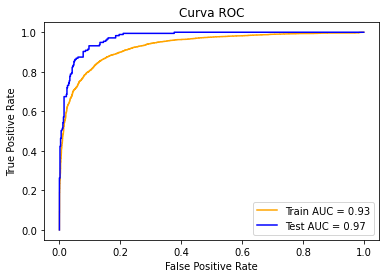

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9723265306122448
Exito min:  0.4690346331654924 
Exito max:  0.91531146 
Exito promedio:  0.7509637304964724
Exito * accuracy =  0.6941050480445966
Exito * accuracy / (Exito + accuracy) =  0.414329370594027
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       525
           1       0.83      0.86      0.85       175

    accuracy                           0.92       700
   macro avg       0.89      0.90      0.90       700
weighted avg       0.92      0.92      0.92       700



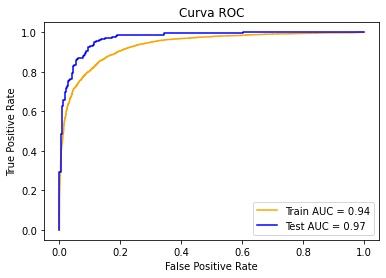

Parcelas con acierto:  34 de 35   97.14%
Test ROC AUC: 0.971243537414966
Exito min:  0.56525683 
Exito max:  0.9140096 
Exito promedio:  0.7547906006477265
Exito * accuracy =  0.695485624882548
Exito * accuracy / (Exito + accuracy) =  0.4149132980152377
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       525
           1       0.54      0.55      0.55       175

    accuracy                           0.77       700
   macro avg       0.69      0.70      0.70       700
weighted avg       0.77      0.77      0.77       700



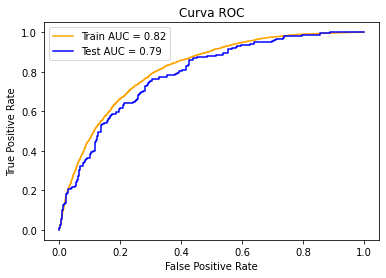

Parcelas con acierto:  31 de 35   88.57%
Test ROC AUC: 0.7878204081632654
Exito min:  0.39844609124050734 
Exito max:  0.98157996 
Exito promedio:  0.6470872275515739
Exito * accuracy =  0.4982571652147119
Exito * accuracy / (Exito + accuracy) =  0.3516065599402759
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       525
           1       0.84      0.77      0.81       175

    accuracy                           0.91       700
   macro avg       0.88      0.86      0.87       700
weighted avg       0.91      0.91      0.91       700



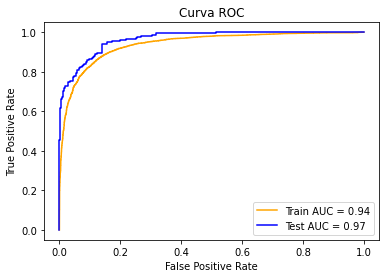

Parcelas con acierto:  34 de 35   97.14%
Test ROC AUC: 0.9652571428571428
Exito min:  0.3806952023546518 
Exito max:  0.88675076 
Exito promedio:  0.7190582100560444
Exito * accuracy =  0.6522885191222688
Exito * accuracy / (Exito + accuracy) =  0.40111185036043706
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       525
           1       0.87      0.74      0.80       175

    accuracy                           0.91       700
   macro avg       0.89      0.85      0.87       700
weighted avg       0.91      0.91      0.90       700



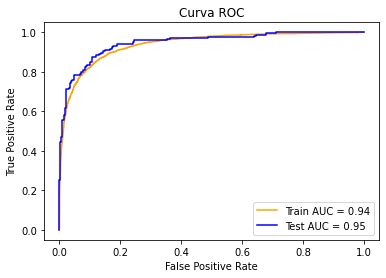

Parcelas con acierto:  33 de 35   94.29%
Test ROC AUC: 0.9477768707482993
Exito min:  0.28838435015120406 
Exito max:  0.91703904 
Exito promedio:  0.7023120060552296
Exito * accuracy =  0.6370973197786726
Exito * accuracy / (Exito + accuracy) =  0.3958466523955326
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       525
           1       0.63      0.37      0.47       175

    accuracy                           0.79       700
   macro avg       0.72      0.65      0.67       700
weighted avg       0.77      0.79      0.77       700



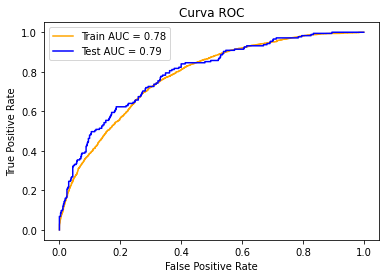

Parcelas con acierto:  25 de 35   71.43%
Test ROC AUC: 0.7919619047619048
Exito min:  0.12189178 
Exito max:  0.89826024 
Exito promedio:  0.5796263571207856
Exito * accuracy =  0.4570767844723909
Exito * accuracy / (Exito + accuracy) =  0.33407215627172016
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       510
           1       0.71      0.78      0.75       170

    accuracy                           0.87       680
   macro avg       0.82      0.84      0.83       680
weighted avg       0.87      0.87      0.87       680



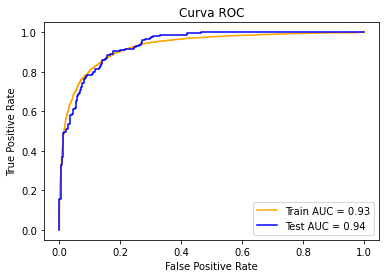

Parcelas con acierto:  33 de 34   97.06%
Test ROC AUC: 0.9371856978085352
Exito min:  0.47989651645688125 
Exito max:  0.9138363 
Exito promedio:  0.7115439203194213
Exito * accuracy =  0.6163226015707929
Exito * accuracy / (Exito + accuracy) =  0.39064120938198993
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       510
           1       0.81      0.79      0.80       170

    accuracy                           0.90       680
   macro avg       0.87      0.86      0.87       680
weighted avg       0.90      0.90      0.90       680



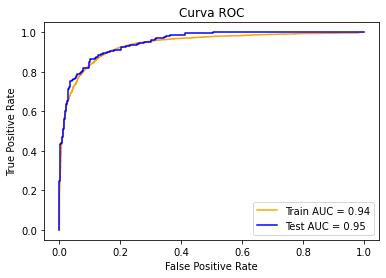

Parcelas con acierto:  33 de 34   97.06%
Test ROC AUC: 0.9510034602076125
Exito min:  0.477866288337581 
Exito max:  0.8821586 
Exito promedio:  0.7182738791476291
Exito * accuracy =  0.6475027763492598
Exito * accuracy / (Exito + accuracy) =  0.3997561278264171
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       510
           1       0.77      0.73      0.75       170

    accuracy                           0.88       680
   macro avg       0.84      0.83      0.83       680
weighted avg       0.87      0.88      0.88       680



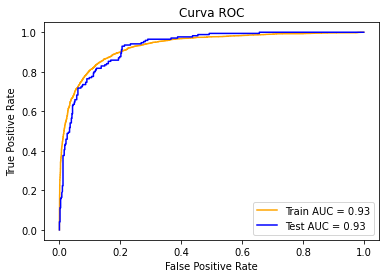

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9286447520184544
Exito min:  0.39178693604673925 
Exito max:  0.91719323 
Exito promedio:  0.6917574033438662
Exito * accuracy =  0.606305018224918
Exito * accuracy / (Exito + accuracy) =  0.3866179034429722
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       510
           1       0.68      0.58      0.62       170

    accuracy                           0.83       680
   macro avg       0.77      0.74      0.76       680
weighted avg       0.82      0.83      0.82       680



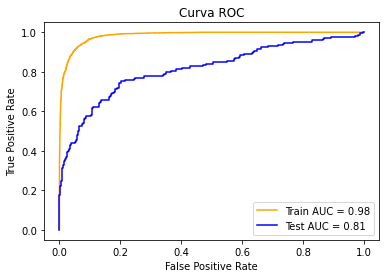

Parcelas con acierto:  27 de 34   79.41%
Test ROC AUC: 0.8140830449826989
Exito min:  0.2789615404065801 
Exito max:  0.9223613 
Exito promedio:  0.6371369250440228
Exito * accuracy =  0.52657492922756
Exito * accuracy / (Exito + accuracy) =  0.3597787825287473


In [25]:
carpeta = "Optuna-XGBoost-2-20230214"
num_trial_best = obtenerParametrosOptimosXGBoost(carpeta = carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials=500)

# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo(best_model, umbral=0.6)

Voy a repetirlo pero con otro rango de parametros con logaritmos (modelo probabilistico) y usando la media de Test ROC AUC de todos los pliegues en vez de solo el maximo.

In [19]:
def obtenerParametrosOptimosXGBoost2(carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials = 100):
    import warnings
    warnings.filterwarnings("ignore")
    import pandas as pd
    import numpy as np

    df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
    parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
    parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    df = df[~df['parcela'].isin(parcelasAQuitar2)]
    df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
    df = quitarDatosMalos(df)
    df = df.astype(float)


    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    import optuna
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_auc_score
    import joblib


    import os

    def objective(trial):
        # Definir los parámetros a optimizar
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_uniform('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 10),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 10),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'n_jobs': -1
        }

        # Crear el modelo XGBoost con los parámetros optimizados
        model = xgb.XGBClassifier(**params)

        # Definir la k-fold cross-validation
        parcelas = df['parcela'].unique() # obtenemos las parcelas
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        scores = []
        for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
            # obtenemos las parcelas de train y test
            parcelasTrain = parcelas[train_index]
            parcelasTest = parcelas[test_index]

            # separamos en 2 df segun las parcelas de train o test
            df_train = df[df['parcela'].isin(parcelasTrain)]
            df_test = df[df['parcela'].isin(parcelasTest)]

            # preparo la normalizacion
            scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

            # arreglamos undersampling en los datos de train
            smote = SMOTE(sampling_strategy=1, random_state=random_state)
            X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_train)

            # preparamos datos de test
            X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
            X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_test)

            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, y_pred)
            scores.append(score)

        # Calcular el valor medio del ROC AUC para todos los folds
        score = np.mean(scores)

        # Guardar el modelo con los parámetros y la puntuación
        filename = os.path.join(carpeta, f"model_trial_{trial.number}.joblib")
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
        joblib.dump((params, score, model), filename)

        return score
    
    
    # Crear el optimizador de Optuna
    study = optuna.create_study(direction='maximize')

    # Ejecutar la optimización
    study.optimize(objective, n_trials=n_trials)

    # Obtener el mejor conjunto de parámetros y su puntuación
    best_params = study.best_params
    best_score = study.best_value

    print(f'Best params: {best_params}')
    print(f'Best ROC AUC: {best_score}')

    # obtiene el número de prueba del mejor modelo
    best_trial = study.best_trial
    num_trial_best = best_trial.number
    
    # muestra el número de prueba del mejor modelo
    print(f"El mejor modelo fue el número de prueba {num_trial_best}.")
    
    return num_trial_best

In [20]:
carpeta = "Optuna-XGBoost2-20230214"
num_trial_best = obtenerParametrosOptimosXGBoost2(carpeta = carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials=10)

[I 2023-03-06 13:45:55,502] A new study created in memory with name: no-name-0ab90a6c-8df6-4673-9fbe-ce048800d5e3
[I 2023-03-06 13:46:58,083] Trial 0 finished with value: 0.8280388362403783 and parameters: {'n_estimators': 416, 'max_depth': 115, 'learning_rate': 0.041813784800662265, 'subsample': 0.7796457762857941, 'colsample_bytree': 0.6929255072202936, 'gamma': 0.8329079833697035, 'min_child_weight': 10, 'reg_alpha': 1.441461862623447, 'reg_lambda': 0.004274615115965492}. Best is trial 0 with value: 0.8280388362403783.
[I 2023-03-06 13:49:54,599] Trial 1 finished with value: 0.840404727538074 and parameters: {'n_estimators': 739, 'max_depth': 149, 'learning_rate': 0.012636246241761032, 'subsample': 0.8621821802419971, 'colsample_bytree': 0.8167433535927592, 'gamma': 0.16728997469119944, 'min_child_weight': 5, 'reg_alpha': 0.7131615313767985, 'reg_lambda': 1.5714201355911204}. Best is trial 1 with value: 0.840404727538074.
[I 2023-03-06 13:51:57,803] Trial 2 finished with value: 0.84

Best params: {'n_estimators': 327, 'max_depth': 63, 'learning_rate': 0.012570431465702933, 'subsample': 0.9512572110063305, 'colsample_bytree': 0.8993729416496435, 'gamma': 0.7575891922166315, 'min_child_weight': 1, 'reg_alpha': 0.0012350114202702015, 'reg_lambda': 0.01727248030523132}
Best ROC AUC: 0.8425890770425817
El mejor modelo fue el número de prueba 2.


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       525
           1       0.95      0.98      0.96       175

    accuracy                           0.98       700
   macro avg       0.97      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700



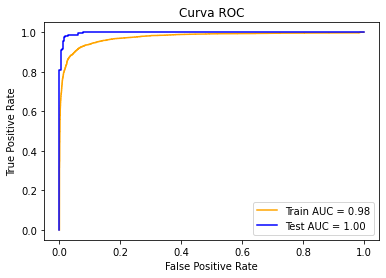

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9976925170068027
Exito min:  0.6117524331479685 
Exito max:  0.9787956 
Exito promedio:  0.8979101482620393
Exito * accuracy =  0.88123467408003
Exito * accuracy / (Exito + accuracy) =  0.46890678345897363
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       525
           1       0.94      0.96      0.95       175

    accuracy                           0.98       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.98      0.98      0.98       700



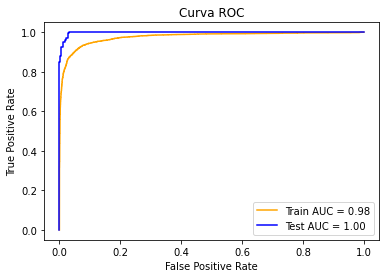

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9981931972789116
Exito min:  0.6085927989065071 
Exito max:  0.9732276 
Exito promedio:  0.9037240076802442
Exito * accuracy =  0.8817764246365811
Exito * accuracy / (Exito + accuracy) =  0.4691701918257549
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       525
           1       0.68      0.65      0.66       175

    accuracy                           0.83       700
   macro avg       0.78      0.77      0.78       700
weighted avg       0.83      0.83      0.83       700



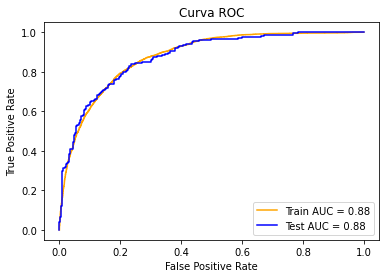

Parcelas con acierto:  31 de 35   88.57%
Test ROC AUC: 0.8770721088435374
Exito min:  0.34831349964542685 
Exito max:  0.9789186 
Exito promedio:  0.7350624509380173
Exito * accuracy =  0.6132521019254316
Exito * accuracy / (Exito + accuracy) =  0.39076867422724154
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       525
           1       0.99      0.91      0.95       175

    accuracy                           0.98       700
   macro avg       0.98      0.96      0.97       700
weighted avg       0.98      0.98      0.98       700



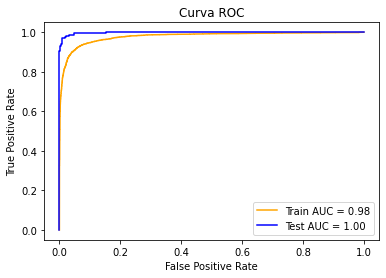

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9980952380952381
Exito min:  0.5399369553613778 
Exito max:  0.9819173 
Exito promedio:  0.842058128662629
Exito * accuracy =  0.8228110857217689
Exito * accuracy / (Exito + accuracy) =  0.45229256807897644
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       525
           1       0.96      0.90      0.93       175

    accuracy                           0.97       700
   macro avg       0.97      0.95      0.96       700
weighted avg       0.97      0.97      0.97       700



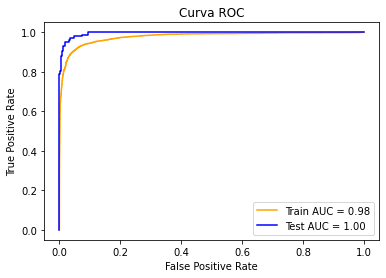

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9959727891156462
Exito min:  0.4406698 
Exito max:  0.9775309 
Exito promedio:  0.8454075044164778
Exito * accuracy =  0.8176298292713651
Exito * accuracy / (Exito + accuracy) =  0.4510935787560457
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       525
           1       0.59      0.36      0.45       175

    accuracy                           0.78       700
   macro avg       0.70      0.64      0.65       700
weighted avg       0.76      0.78      0.76       700



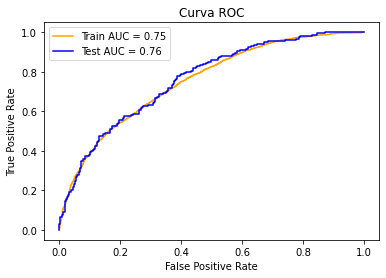

Parcelas con acierto:  23 de 35   65.71%
Test ROC AUC: 0.7606095238095238
Exito min:  0.0980015323009507 
Exito max:  0.95057815 
Exito promedio:  0.579250335324289
Exito * accuracy =  0.45016026059487607
Exito * accuracy / (Exito + accuracy) =  0.331880359688387
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       510
           1       0.86      0.94      0.90       170

    accuracy                           0.95       680
   macro avg       0.92      0.94      0.93       680
weighted avg       0.95      0.95      0.95       680



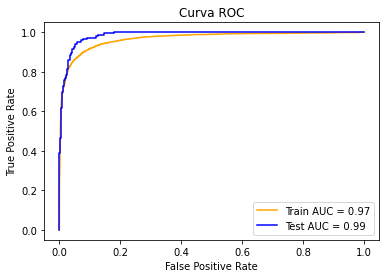

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9856055363321798
Exito min:  0.566094 
Exito max:  0.9780739 
Exito promedio:  0.8505287915835115
Exito * accuracy =  0.8042500191002909
Exito * accuracy / (Exito + accuracy) =  0.4477715021155384
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       510
           1       0.95      0.92      0.93       170

    accuracy                           0.97       680
   macro avg       0.96      0.95      0.96       680
weighted avg       0.97      0.97      0.97       680



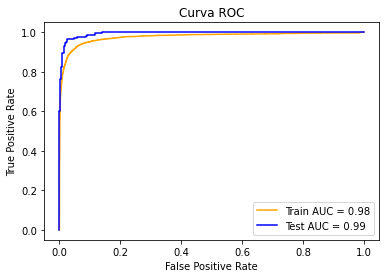

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9943021914648213
Exito min:  0.6507064513687298 
Exito max:  0.9787243 
Exito promedio:  0.8709023680219763
Exito * accuracy =  0.8427261149389124
Exito * accuracy / (Exito + accuracy) =  0.45836467741028925
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       510
           1       0.90      0.83      0.86       170

    accuracy                           0.93       680
   macro avg       0.92      0.90      0.91       680
weighted avg       0.93      0.93      0.93       680



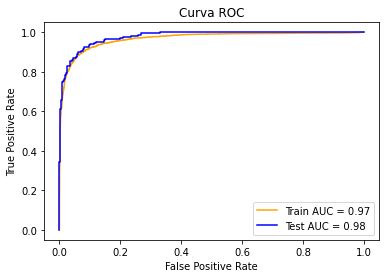

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9779930795847751
Exito min:  0.41085161548494953 
Exito max:  0.9808648 
Exito promedio:  0.7996032051248357
Exito * accuracy =  0.7466882871386333
Exito * accuracy / (Exito + accuracy) =  0.43075849256371745
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       510
           1       0.69      0.59      0.64       170

    accuracy                           0.83       680
   macro avg       0.78      0.75      0.76       680
weighted avg       0.82      0.83      0.83       680



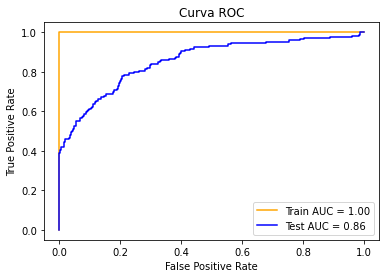

Parcelas con acierto:  27 de 34   79.41%
Test ROC AUC: 0.8559630911188004
Exito min:  0.2447801356107863 
Exito max:  0.97872514 
Exito promedio:  0.7018907593118485
Exito * accuracy =  0.5831886456046977
Exito * accuracy / (Exito + accuracy) =  0.3804794336113243


In [22]:
# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo(best_model, umbral=0.6, n_splits=10)

El mejor modelo:
 - 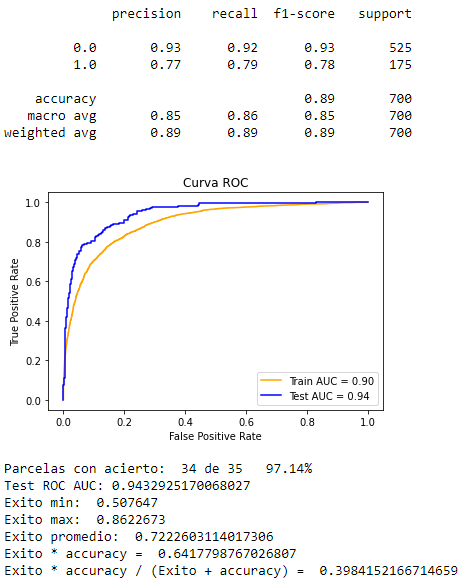

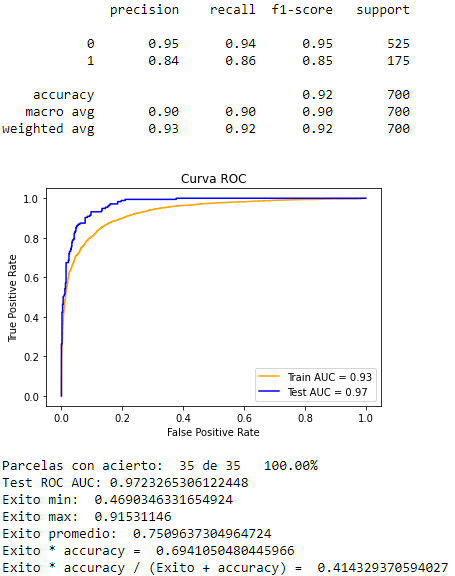
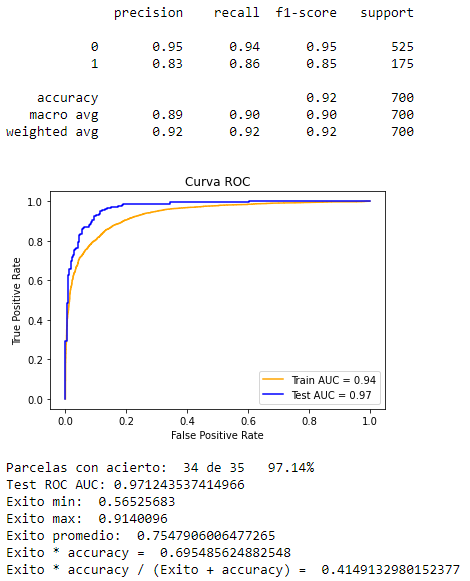
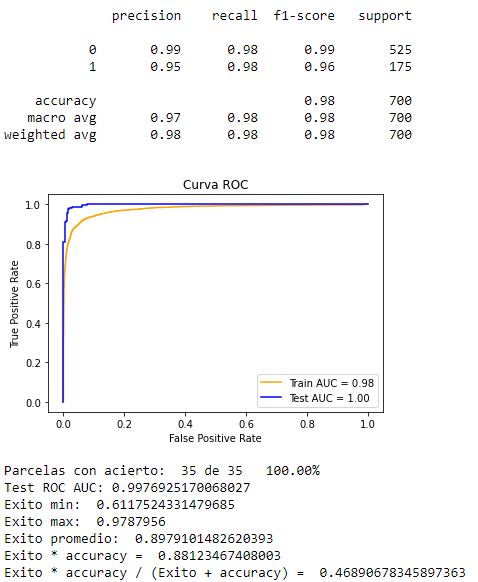